<a href="https://colab.research.google.com/github/green-nk/practical-deep-learning/blob/main/projects/01_horapa_vs_kaprao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Scenario: What would be happier than eating good food? Except one thing that blocks you from doing that **Horapa** or **Thai Basil**. 

In Thailand, favourite main dish of most people would be **Minched Pork Kaprao (Holy Basil) with fried egg** like this image:

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fs.isanook.com%2Fwo%2F0%2Fud%2F36%2F180929%2F3.jpg%3Fip%2Fresize%2Fw728%2Fq80%2Fjpg&f=1&nofb=1&ipt=3cc4b1dd92ce0d94b10a8d7cadf1296cdbfff0a45345a6dc9f782366957bc973&ipo=images)

However, it is quite hard for an excellent cook like you to eyeball and pick which one is **Kaprao** or **Horapa**. If you choose the wrong ingredient, this can cause negative effect to the taste of the delicious **Kaprao** and you do not want it to happen Right?

Therefore, the objective of this project is to let the machine help you classify which one is **Kaprao** that you want and ditch the ugly taste (in my opinion) **Horapa** out!

## Setup

In [ ]:
!pip install -Uqq fastai duckduckgo-search

In [ ]:
!git clone https://github.com/TAUTOLOGY-EDUCATION/DATASET.git

Cloning into 'DATASET'...
remote: Enumerating objects: 1301, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1301 (delta 4), reused 12 (delta 3), pack-reused 1285
Receiving objects: 100% (1301/1301), 1.96 GiB | 15.75 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Filtering content: 100% (3/3), 5.02 GiB | 31.48 MiB/s, done.


In [ ]:
# !unzip /content/DATASET/HorapaVsKaprao/horapa.zip -d data/
!unzip /content/DATASET/HorapaVsKaprao/kaprao.zip -d data/

## Data Preprocessing

In [ ]:
from fastai.vision.all import Image, get_image_files, verify_images
from pathlib import Path

In [ ]:
def remove_invalid_images(path, suffixes):
    """
    Remove invalid images from in dataset folder.
    """
    for suffix in suffixes:
        filename = path/suffix
        failed = verify_images(get_image_files(filename))
        print(f"In {filename}, There are {len(failed)} as unverified images: {failed}")

        if failed:
            print(f"Unlinking those files permanently...")
            failed.map(Path.unlink)

In [ ]:
# Horapa; shape is hxw
im = Image.open("/content/data/horapa/20220425_221530.jpg")
im.to_thumb(256, 256)

In [ ]:
!mkdir /content/data

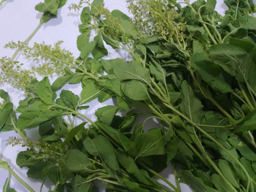

In [ ]:
# Kaprao; shape is hxw
im = Image.open("/content/data/kaprao/20220425_205023(0).jpg")
im.to_thumb(256, 256)

In [ ]:
path = Path("data")
suffixes = ["horapa", "kaprao"]
remove_invalid_images(path, suffixes)

In data/horapa, There are 0 as unverified images: []
In data/kaprao, There are 0 as unverified images: []


## Training (Fine-Tuning)

### High-level APIs

In [ ]:
from fastai.vision.all import Resize, resnet34, resnet50, error_rate
from fastai.vision.data import ImageDataLoaders, DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label
from fastai.vision.learner import vision_learner

In [ ]:
dls = ImageDataLoaders.from_folder(
    path=path,
    valid_pct=0.2,
    seed=42,
    item_tfms=[Resize(192, method="squish")] # squeeze image together as opposed to cropping
)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 71.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.694487,0.487230,0.130045,05:09


epoch,train_loss,valid_loss,error_rate,time
0,0.091465,0.059424,0.013453,05:27
1,0.060115,0.046082,0.013453,05:01
2,0.038788,0.024715,0.004484,04:47


### Low-level APIs

In [ ]:
!git clone https://github.com/green-nk/practical-deep-learning.git

fatal: destination path 'practical-deep-learning' already exists and is not an empty directory.


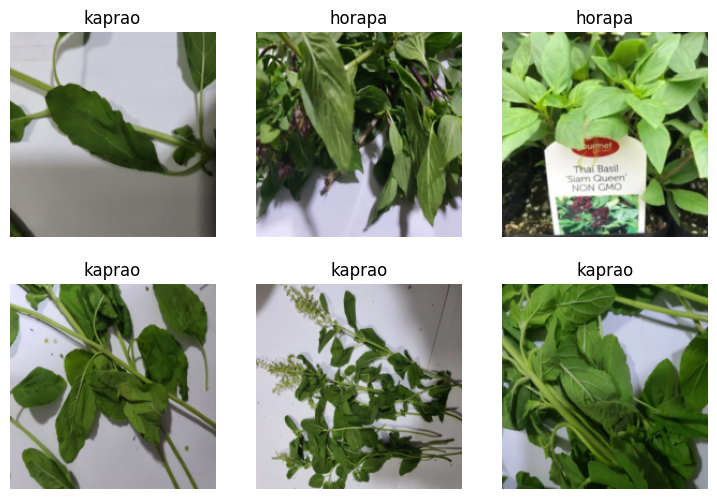

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.530663,0.155693,0.051282,04:41


epoch,train_loss,valid_loss,error_rate,time
0,0.067890,0.125125,0.047009,04:41
1,0.049642,0.106105,0.034188,04:43
2,0.040295,0.058687,0.021368,04:45


## Testing

### Test set

In [ ]:
import time
from duckduckgo_search import DDGS
from fastcore.all import L
from fastai.vision.all import download_images, resize_images

In [ ]:
def fetch_images(path, searches):
    """
    Fetch images from the given search keywords.
    """
    for s in searches:
        dest = path/searches[s]
        dest.mkdir(exist_ok=True, parents=True)

        download_images(dest, urls=search_images(f"{s} photo"))
        resize_images(dest, dest=dest, max_size=256)

        # Pause between search to avoid over-loading server
        time.sleep(10)


def search_images(term, max_images=30):
    """
    Get image urls from the given term.
    """
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
            term,
            max_results=max_images
        )

        print(f"Searching for '{term}' ...")
        urls = L(ddgs_images_gen).itemgot("image")

    return urls

In [ ]:
searches = {"thai basil": "horapa", "holy basil": "kaprao"}
path = Path("data/horapa_or_kaprao")

fetch_images(path, searches)

Searching for 'thai basil photo' ...
Searching for 'holy basil photo' ...


In [ ]:
suffixes = [searches[s] for s in searches]
remove_invalid_images(path, suffixes)

In data/horapa_or_kaprao/horapa, There are 2 as unverified images: [Path('data/horapa_or_kaprao/horapa/b8da4f65-a792-42d3-8fc5-a00860a8e4e3.jpg'), Path('data/horapa_or_kaprao/horapa/f5f06ff6-350b-4d80-a9e0-2abef805f542.jpg')]
Unlinking those files permanently...
In data/horapa_or_kaprao/kaprao, There are 1 as unverified images: [Path('data/horapa_or_kaprao/kaprao/9fa62a32-2e1b-482b-88af-c66e58868e44.jpg')]
Unlinking those files permanently...


### Prediction

In [ ]:
from fastai.vision.all import PILImage
from sklearn.metrics import classification_report

In [ ]:
def prediction(path, print_logs=False):
    """
    Make a prediction.
    """
    folders = path.ls()
    y_true = list()
    y_pred = list()

    for f in folders:
        label = f.stem
        image_files = get_image_files(f)

        true_idx = 0 if label == "horapa" else 1

        for image_file in image_files:
            # Load an image as Pillow Image (TensorImage) for making a prediction
            img = PILImage.create(image_file)
            is_horapa, pred_idx, probs = learn.predict(img)

            if print_logs:
                print(f"I'm {probs[pred_idx]:.2%} sure this is {is_horapa}. Actually it is {label}!")
                print(f"Filename: {image_file}")
                print("*" * 100)

            y_true.append(true_idx)
            y_pred.append(pred_idx.item())

    return y_true, y_pred

In [ ]:
path = Path("/content/data/horapa_or_kaprao/")
y_true, y_pred = prediction(path, print_logs=True)

I'm 97.33% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/8016868a-8f05-44d3-9302-1f0089e8fd47.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/9e7fbf29-eec6-4e71-984e-810824dda08a.jpg
****************************************************************************************************


I'm 99.87% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/ebb0eb78-e8d7-415d-87cb-9ed823294335.jpg
****************************************************************************************************


I'm 54.40% sure this is kaprao. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/8fe1e71e-5501-4b68-b231-5f21d0f14d97.jpg
****************************************************************************************************


I'm 98.75% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/69bd51b6-63cc-4af3-8286-89decca25f29.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/cf4af64d-1680-45d8-9769-009c3fdde7fb.jpg
****************************************************************************************************


I'm 99.99% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/3a002185-6384-47a6-b185-8d13c6d08d48.jpg
****************************************************************************************************


I'm 56.21% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/609b95ce-70a3-433c-8a58-b2a130f811ff.jpg
****************************************************************************************************


I'm 62.23% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/6989940f-4d33-4539-aafe-b3a9fa1ee64d.png
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/3dbaeca5-3d96-4ad0-882c-9aad564dbd8b.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/d54c5c2f-261c-46d5-b4c5-88fcfc799957.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/cfb38967-65cb-43af-b751-93cd7bf169e7.JPG
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/70856781-9034-482a-83f4-824c5b31de96.jpg
****************************************************************************************************


I'm 99.85% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/93bb4aa3-7a10-4068-a28b-78160a475c08.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/04ea0a94-6f05-4fad-83db-3656c1b5c119.png
****************************************************************************************************


I'm 99.68% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/10491f8f-0a56-4221-b6fe-1771b3724487.jpg
****************************************************************************************************


I'm 80.66% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/6ae69c09-95d2-43b9-9439-9fed88d3f334.jpg
****************************************************************************************************


I'm 99.16% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/ace55c7b-8a4d-444c-9e47-9c2b5d766e8d.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/4410b4dd-66c2-4e7d-8e4e-5d24dbfc23d9.jpg
****************************************************************************************************


I'm 99.97% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/5aa92159-5f07-42d7-a5ef-8a8c231728b2.jpg
****************************************************************************************************


I'm 86.71% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/afd83e65-61b9-479d-bff7-9383e40eeaef.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/4a7dc58a-f8af-4a4c-86ee-7f82bb6f124a.jpg
****************************************************************************************************


I'm 99.80% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/90cf0469-dcc7-4e59-ac5b-6be817a043e9.jpeg
****************************************************************************************************


I'm 99.94% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/83af1def-3798-446c-b5b7-6dd8ccdd15c8.jpg
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/07b37344-b80e-4748-bf9b-3e7669410db7.png
****************************************************************************************************


I'm 100.00% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/de27388f-459a-4981-a693-7cd37396e82e.png
****************************************************************************************************


I'm 99.99% sure this is horapa. Actually it is horapa!
Filename: /content/data/horapa_or_kaprao/horapa/e483bc0d-5164-44a1-9620-a21ffeb7ea0b.jpg
****************************************************************************************************


I'm 98.87% sure this is horapa. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/8182e44a-63a3-4a07-b86c-8ab19f72efe0.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/e0489fc9-431d-4e69-93bf-f3a7e5e0da59.jpg
****************************************************************************************************


I'm 99.71% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/7d977b0c-5cdb-472f-b756-5f93a16c9780.jpg
****************************************************************************************************


I'm 95.90% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/97597598-64c5-4a25-b4fb-084450b0f105.jpeg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/79412a00-da2a-4daf-9d9b-ae6148fe1ef7.png
****************************************************************************************************


I'm 99.99% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/6967eb32-9074-4297-aec7-758cb75f9cf4.jpeg
****************************************************************************************************


I'm 99.96% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/fd3e30ec-6a3b-4975-acfe-d3184700edd7.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/a0e12e47-f54d-4ea7-8c6c-7258b287d00e.jpg
****************************************************************************************************


I'm 99.22% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/2c0ed4a0-574a-402a-9fa2-7c1ab3c9abbc.jpeg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/52224063-c2bd-43be-ab6a-55d76fb4095d.jpg
****************************************************************************************************


I'm 96.78% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/2f5f4f90-8cc9-43b6-9744-6c8fda3201d9.jpg
****************************************************************************************************


I'm 99.96% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/c83af2d1-c1bf-403e-b022-7105865a4886.jpg
****************************************************************************************************


I'm 91.69% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/def9a7f1-858e-4322-9ced-22f1b47d3d26.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/075e8294-c1f6-4daa-8c5a-fc016a2ed627.jpg
****************************************************************************************************


I'm 77.44% sure this is horapa. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/52394c99-c39b-41e8-bea4-ee845091b9ab.jpg
****************************************************************************************************


I'm 99.60% sure this is horapa. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/c7f33675-099a-4677-885f-4bbb3e6f3f91.jpg
****************************************************************************************************


I'm 99.89% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/b8771a47-7997-4116-9a5b-f39f09e56a17.jpg
****************************************************************************************************


I'm 79.66% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/a5f73e5d-feaa-4dbd-9b28-81bad8dbd548.jpg
****************************************************************************************************


I'm 99.93% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/177ba493-bcb8-47ed-a794-1d00ae92613f.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/92bb4d81-4500-48c5-ab7d-d421818f99a6.jpg
****************************************************************************************************


I'm 99.99% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/1cac4d3c-5330-4ca9-825a-616d91f09f77.jpg
****************************************************************************************************


I'm 94.60% sure this is horapa. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/a89d4a57-584d-4459-9f56-b57f6a580fb0.jpg
****************************************************************************************************


I'm 64.10% sure this is horapa. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/4fa62404-acf1-4b91-ab71-cf32f1a14f19.jpg
****************************************************************************************************


I'm 97.62% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/71ec72cc-8b98-46c8-9d8b-6930c65b2408.jpg
****************************************************************************************************


I'm 99.93% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/f7169de3-00cb-4cee-9194-d6c5768c28a2.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/db5243db-00fb-46f0-89a8-1819ea7560bd.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/598229b9-170a-476e-91d2-35558ea3b9b7.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/f9675694-0865-4742-a27d-465327bcd012.jpg
****************************************************************************************************


I'm 100.00% sure this is kaprao. Actually it is kaprao!
Filename: /content/data/horapa_or_kaprao/kaprao/e0945fb8-5919-4407-a7e5-f006f780046e.jpg
****************************************************************************************************


In [ ]:
# F1-score for positive class; resnet34
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73        27
           1       0.92      0.38      0.54        29

    accuracy                           0.66        56
   macro avg       0.75      0.67      0.63        56
weighted avg       0.76      0.66      0.63        56



In [ ]:
# F1-score for positive class; resnet50
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        27
           1       0.96      0.83      0.89        29

    accuracy                           0.89        56
   macro avg       0.90      0.90      0.89        56
weighted avg       0.90      0.89      0.89        56



In [ ]:
!git clone https://github.com/green-nk/quarto-basic.git

Cloning into 'quarto-basic'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 112 (delta 25), reused 109 (delta 22), pack-reused 0
Receiving objects: 100% (112/112), 558.55 KiB | 13.30 MiB/s, done.
Resolving deltas: 100% (25/25), done.
